In [1]:
import os
from functools import reduce

import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def plot_side_by_side(images, titles=None, max_per_column=4, labels=True):
    titles = titles or [''] * len(images)
    if len(images) <= max_per_column:
        for i, (image, title) in enumerate(zip(images, titles), 1):
            plt.subplot(1, len(images), i)
            plt.imshow(image, cmap='gray')
            plt.title(title)
            if not labels:
                plt.xticks([])
                plt.yticks([])
    else:
        shape = (np.ceil(len(images) / max_per_column), max_per_column)
        for i in range(int(shape[0])):
            for j in range(int(shape[1])):
                index = i * max_per_column + j
                if index >= len(images):
                    break
                plt.subplot(int(shape[0]), int(shape[1]), index + 1)
                plt.imshow(images[index], cmap='gray')
                plt.title(titles[index])
                if not labels:
                    plt.xticks([])
                    plt.yticks([])

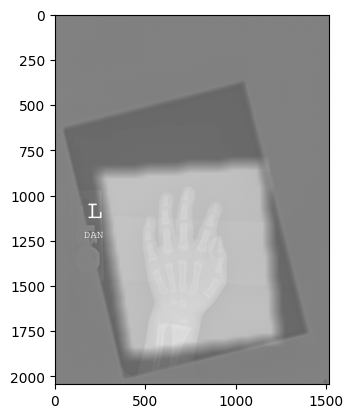

In [3]:
image = cv2.imread('./data/train/images/1378.png', 0)
plt.imshow(image, cmap='gray')

In [4]:
def find_peaks(arr, width=3, min_amount=200):
    peaks = []
    for i in range(1, len(arr)):
        if arr[i] > min_amount and \
                all(arr[i] >= x for x in arr[max(0, i - width // 2):min(len(arr), i + 1 + width // 2)]):
            peaks.append((i, arr[i]))
    return peaks

In [5]:
def find_valleys(histogram, peaks):
    valleys = []
    previous = peaks[0][0]
    for pos, _ in peaks[1:]:
        sublist = histogram[previous:pos]
        valley = sublist.argmin() + previous
        valleys.append((valley, histogram[valley]))
        previous = pos
    return valleys

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(1, 225.0), (2, 225.0), (106, 72354.80000000002), (129, 310188.2), (191, 71124.8), (206, 19634.2), (253, 707.4000000000001), (254, 707.4000000000001), (255, 707.4000000000001)]
[(1, 225.0), (3, 0.0), (122, 7057.0), (175, 2878.6000000000004), (198, 8407.6), (230, 0.0), (253, 707.4000000000001), (254, 707.4000000000001)]


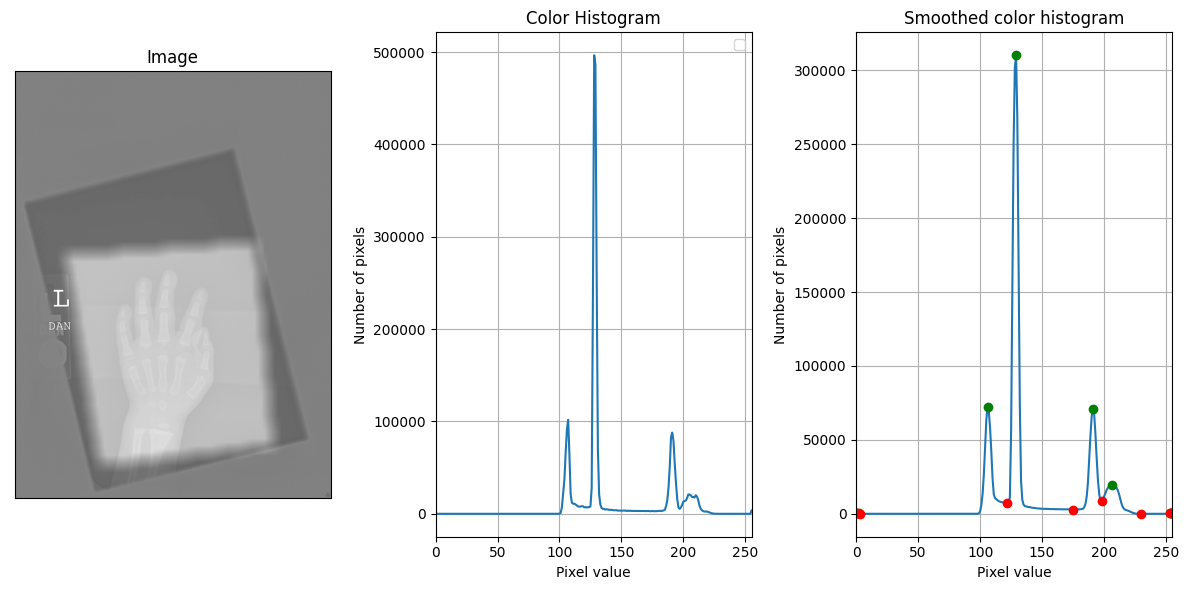

In [6]:
def plot_histograms(image, plot_non_smooth=True):
    hist, bin = np.histogram(image.ravel(), 256, [0, 255])
    smooth = np.convolve(hist, np.ones((5,)) / 5, mode='same')
    peaks = find_peaks(smooth, 9)
    valleys = find_valleys(smooth, peaks)

    n_plots = 3 if plot_non_smooth else 2

    plt.subplot(1, n_plots, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.xticks([])
    plt.yticks([])

    if plot_non_smooth:
        plt.subplot(1, n_plots, 2)
        plt.xlim([0, 255])
        plt.ylabel('Number of pixels')
        plt.xlabel('Pixel value')
        plt.plot(hist)
        plt.title('Color Histogram')
        plt.legend()
        plt.grid()


    plt.subplot(1, n_plots, n_plots)
    plt.xlim([0, 255])
    plt.plot(smooth)
    plt.plot([x for x, _ in peaks], [x for _, x in peaks], 'go')
    plt.plot([x for x, _ in valleys], [x for _, x in valleys], 'ro')
    plt.title('Smoothed color histogram')
    plt.ylabel('Number of pixels')
    plt.xlabel('Pixel value')
    plt.grid()

    return peaks, valleys

plt.figure(figsize=(12, 6))
peaks, valleys = plot_histograms(image)
plt.tight_layout()
print(peaks)
print(valleys)

In [7]:
def rescale_color(image, skip_zero=True):
    if skip_zero:
        minval = np.min(image[np.nonzero(image)])
        maxval = np.max(image[np.nonzero(image)])
    else:
        minval = np.min(image)
        maxval = np.max(image)

    rescaled = np.interp(image, (minval, maxval), (10 if skip_zero else 0, 255))
    rescaled = rescaled.astype(np.uint8)
    return rescaled


def remove_last_peak(image, rescale=True):
    hist, bin = np.histogram(image.ravel(), 256, [0, 255])
    smooth = np.convolve(hist, np.ones((10,)) / 10, mode='same')
    peaks = find_peaks(smooth, 9)
    valleys = find_valleys(smooth, peaks)

    _, mask = cv2.threshold(image, valleys[-1][0], 255, cv2.THRESH_BINARY)
    _, image = cv2.threshold(image, valleys[-1][0], 255, cv2.THRESH_TOZERO_INV)

    if rescale:
        return rescale_color(image), mask
    return image, mask

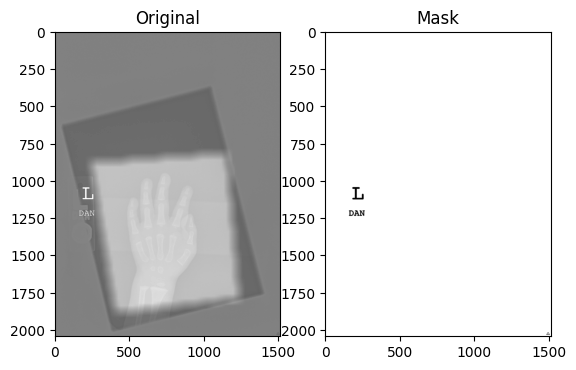

In [8]:
_, mask = cv2.threshold(image, valleys[0][0], 255, cv2.THRESH_TOZERO)
_, mask = cv2.threshold(mask, valleys[-1][0], 255, cv2.THRESH_TOZERO_INV)
_, mask = cv2.threshold(mask, valleys[0][0], 255, cv2.THRESH_BINARY)
plot_side_by_side([image, mask], ['Original', 'Mask'])

In [9]:
def remove_noise(image, ellipse_size=5, iterations=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ellipse_size, ellipse_size))
    denoised = image.copy()
    denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel, iterations=iterations)
    denoised = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return denoised

In [10]:
def remove_lines(image, line_width=20):
    padded = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, 0)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (line_width, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, line_width))
    removed = cv2.morphologyEx(padded, cv2.MORPH_OPEN, horizontal_kernel, iterations=3)
    removed = cv2.morphologyEx(removed, cv2.MORPH_OPEN, vertical_kernel, iterations=3)
    removed = removed[1:-1, 1:-1]
    return removed

In [11]:
def get_range_mask(image, lower, upper):
    _, mask = cv2.threshold(image, upper, 255, cv2.THRESH_TOZERO_INV)
    _, mask = cv2.threshold(mask, lower, 255, cv2.THRESH_BINARY)
    return mask

In [34]:
def is_background_component(component):
    binary = component == 255
    width = component.shape[1]
    start = int(width * 0.3)
    end = int(width * 0.7)
    sum_center = np.sum(binary[:, start:end])
    sum_sides = np.sum(binary[:, :start]) + np.sum(binary[:, end:])
    horizontal_centrality = sum_center / (sum_center + sum_sides)

    height = component.shape[0]
    start = int(height * 0.2)
    end = int(height * 0.8)
    sum_center = np.sum(binary[start:end])
    sum_sides = np.sum(binary[:start]) + np.sum(binary[end:])
    vertical_centrality = sum_center / (sum_center + sum_sides)

    return horizontal_centrality < 0.6 or vertical_centrality < 0.6 or horizontal_centrality + vertical_centrality < 1

In [13]:
def get_components(image):
    hist, bin = np.histogram(image.ravel(), 256, [0, 255])
    peaks = find_peaks(hist, 9)
    valleys = [i for i, _ in find_valleys(hist, peaks)]
    iter_valleys = zip([0, *valleys], [*valleys, 255])
    components = [get_range_mask(image, lower, upper) for lower, upper in iter_valleys]
    return components

In [14]:
def get_hand_components(image):
    components = get_components(image)
    hand_components = [component for component in components if not is_background_component(component)]
    if len(hand_components) > 0:
        return reduce(cv2.bitwise_or, hand_components)
    copy = image.copy()
    copy[image != 0] = 255
    return copy

In [15]:
def get_hand(image):
    mask = get_hand_components(image)

    mask = remove_noise(mask)
    mask = remove_lines(mask, line_width=15)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    mask = mask == 255
    masked = image.copy()
    masked[~mask] = 0

    y_nonzero, x_nonzero = np.nonzero(masked)
    cropped = masked[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

    minval = np.min(cropped[np.nonzero(cropped)])
    maxval = np.max(cropped[np.nonzero(cropped)])
    rescaled = np.interp(cropped, (minval, maxval), (0, 255))
    rescaled = rescaled.astype(np.uint8)

    return rescaled

In [16]:
def reshape(image, size, pad=True):
    scale_factor = max(image.shape) / size
    new_size = (int(image.shape[1] / scale_factor), int(image.shape[0] / scale_factor))
    resized = cv2.resize(image, new_size)
    top = int(np.ceil((size - new_size[1]) / 2))
    bottom = int(np.floor((size - new_size[1]) / 2))
    left = int(np.ceil((size - new_size[0]) / 2))
    right = int(np.floor((size - new_size[0]) / 2))
    if pad:
        return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 0)
    return resized

In [17]:
def process_image(src, out, force=False):
    if not force and os.path.exists(out):
        print(f'Image {out} already exists. Skipping')
        return
    try:
        image = cv2.imread(src, 0)
        hand = get_hand(image)
        resized = reshape(hand, 299)
        cv2.imwrite(out, resized)
    except ValueError:
        print(f'Error processing image {src}. Skipping')

In [23]:
def process_folder(src, out, force=False):
    files = os.listdir(src)
    for image in tqdm(files):
        process_image(os.path.join(src, image), os.path.join(out, image), force)

In [ ]:
process_folder('./data/validation/images', './data/validation/reshaped')
process_folder('./data/train/images', './data/train/reshaped')
process_folder('./data/test/images', './data/test/reshaped')

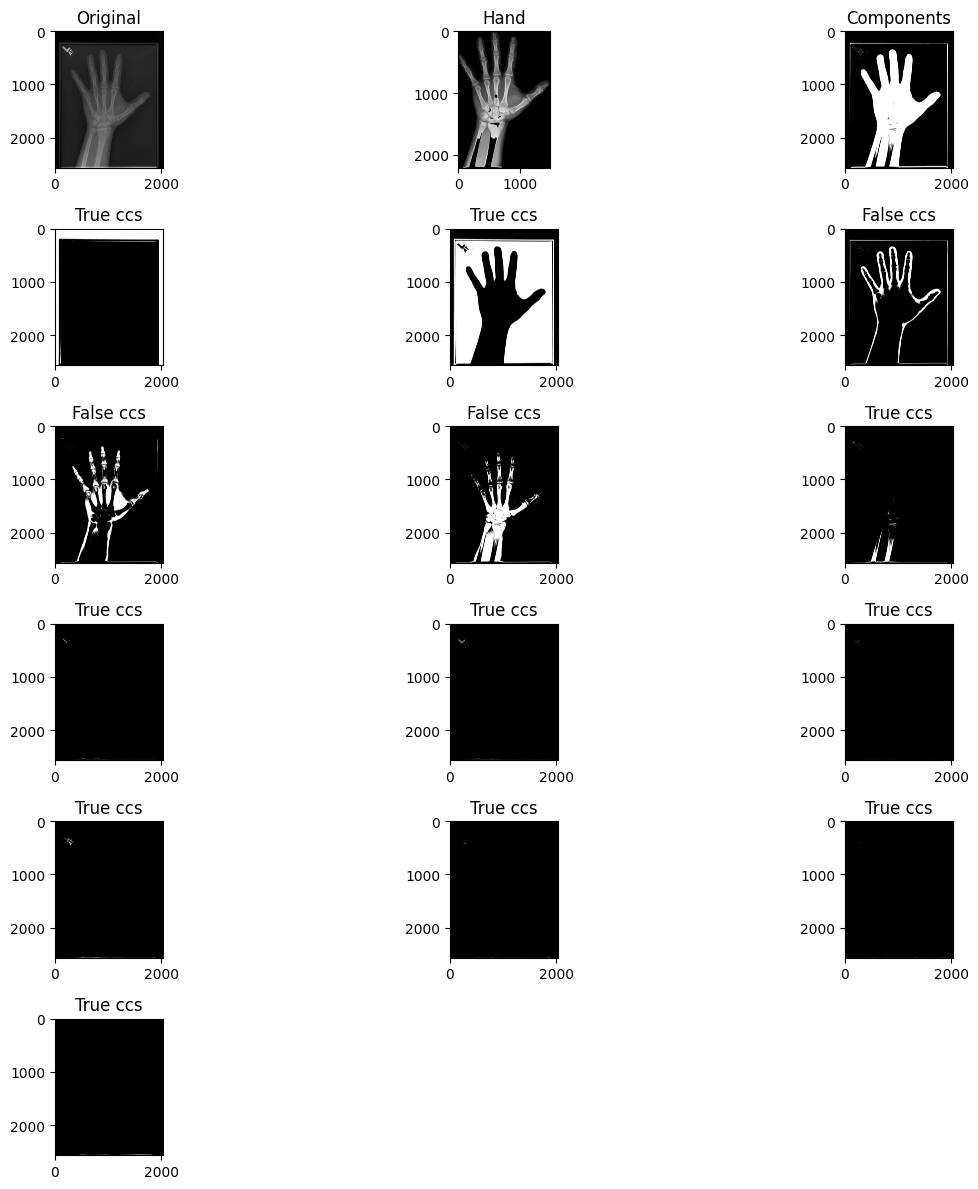

In [118]:
image = cv2.imread('./data/train/images/1854.png', 0)
components = get_components(image)
denoised = [remove_lines(component, line_width=1) for component in components]
plt.figure(figsize=(12, 12))
hand = get_hand(image)
hand_components = get_hand_components(image)
plot_side_by_side([image, hand, hand_components, *denoised],
                  ['Original', 'Hand', 'Components', *[f'{is_background_component(c)} ccs' for c in denoised]],
                  max_per_column=3)
plt.tight_layout()

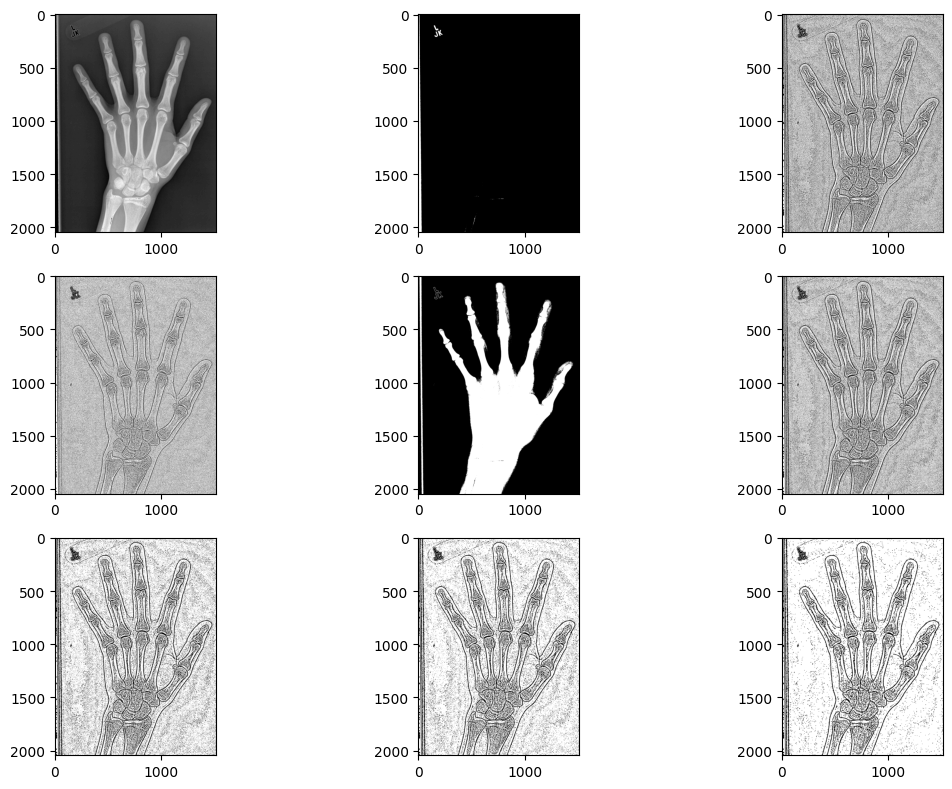

In [72]:
image = cv2.imread('./data/train/images/1377.png', 0)
image, mask = remove_last_peak(image)
mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
gauss = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
_, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
filtered = cv2.bilateralFilter(mean, 7, 200, 200)
mean_median = cv2.medianBlur(mean, 3)
mean_median_2 = cv2.medianBlur(mean_median, 3)
mean_median_3 = cv2.medianBlur(mean_median_2, 3)
for i in range(9):
    mean_median_3 = cv2.medianBlur(mean_median_3, 3)
plt.figure(figsize=(12, 8))
plot_side_by_side([image, mask, mean, gauss, otsu, filtered, mean_median, mean_median_2, mean_median_3],
                  max_per_column=3)
plt.tight_layout()

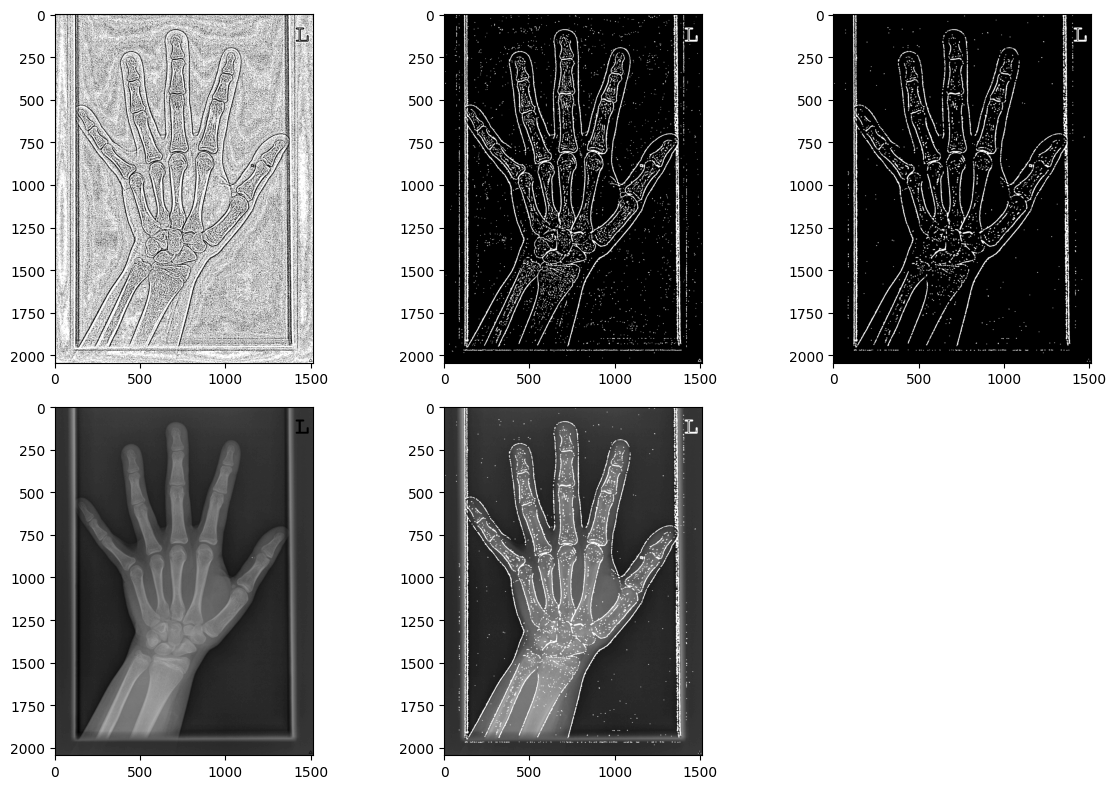

In [161]:
inverted = 255 - mean_median_3
denoised = inverted.copy()
round = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, round)
overlapped = cv2.bitwise_or(image, denoised)

plt.figure(figsize=(12, 8))
plot_side_by_side([mean, inverted, denoised, image, overlapped], max_per_column=3)
plt.tight_layout()

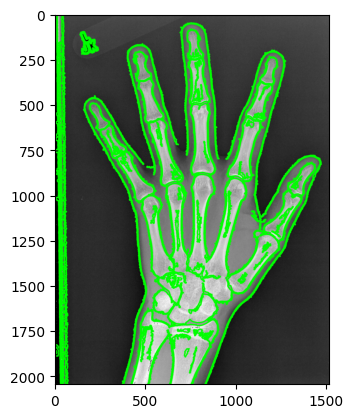

In [117]:
contours, hierarchy = cv2.findContours(image=inverted, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

long_countours = [c for c in contours if cv2.contourArea(c) > 500]

image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image=image_copy, contours=long_countours, contourIdx=-1, color=(0, 255, 0), thickness=5,
                 lineType=cv2.LINE_AA)

plt.imshow(image_copy)

In [165]:
def process_image_contour(src, out, force=False):
    if not force and os.path.exists(out):
        print(f'Image {out} already exists. Skipping')
        return
    try:
        image = cv2.imread(src, 0)

        image, mask = remove_last_peak(image)
        mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        for i in range(15):
            mean_median = cv2.medianBlur(mean, 3)

        inverted = 255 - mean_median
        denoised = inverted.copy()
        round = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, round)

        resized = reshape(denoised, 299)

        cv2.imwrite(out, resized)
    except:
        print(f'Error processing image {src}. Skipping')

In [163]:
def process_folder_contour(src, out, force=False):
    files = os.listdir(src)
    for image in tqdm(files):
        process_image_contour(os.path.join(src, image), os.path.join(out, image), force)

In [ ]:
process_folder_contour('./data/validation/images', './data/validation/contours')
process_folder_contour('./data/train/images', './data/train/contours')
process_folder_contour('./data/test/images', './data/test/contours')

  0%|          | 0/1425 [00:00<?, ?it/s]

Image ./data/validation/contours\10018.png already exists. Skipping
Image ./data/validation/contours\10027.png already exists. Skipping
Image ./data/validation/contours\10028.png already exists. Skipping
Image ./data/validation/contours\10032.png already exists. Skipping
Image ./data/validation/contours\10034.png already exists. Skipping
Image ./data/validation/contours\10050.png already exists. Skipping
Image ./data/validation/contours\10065.png already exists. Skipping
Image ./data/validation/contours\10072.png already exists. Skipping
Image ./data/validation/contours\10082.png already exists. Skipping
Image ./data/validation/contours\10098.png already exists. Skipping
Image ./data/validation/contours\10101.png already exists. Skipping
Image ./data/validation/contours\10119.png already exists. Skipping
Image ./data/validation/contours\10124.png already exists. Skipping
Image ./data/validation/contours\10127.png already exists. Skipping
Image ./data/validation/contours\10129.png alrea

  0%|          | 0/12611 [00:00<?, ?it/s]

Error processing image ./data/train/images\10201.png. Skipping


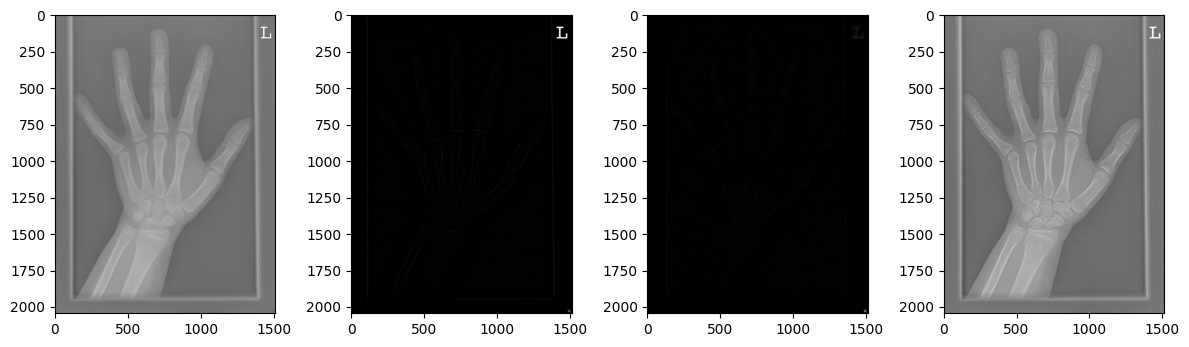

In [8]:
image = cv2.imread('./data/train/images/1396.png', 0)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
denoised = image.copy()
top = cv2.morphologyEx(denoised, cv2.MORPH_TOPHAT, kernel)
bot = cv2.morphologyEx(denoised, cv2.MORPH_BLACKHAT, kernel)
denoised = denoised + top - bot

plt.figure(figsize=(12, 6))
plot_side_by_side([image, top, bot, denoised])
plt.tight_layout()

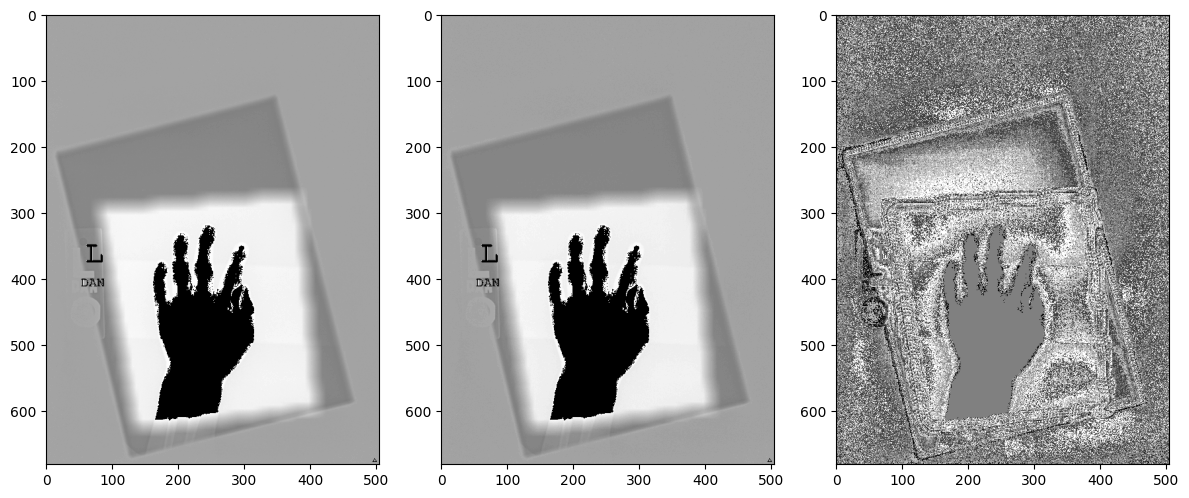

In [35]:
image = cv2.imread('./data/train/images/1378.png', 0)
image = reshape(image, max(500, max(image.shape) // 3), pad=False)
image, mask = remove_last_peak(image)
new_factor = 63
rescaled = np.interp(image, (0, 255), (0, new_factor))
rescaled = rescaled.astype(np.uint8)
rescaled = np.interp(rescaled, (0, new_factor), (0, 255))
rescaled = rescaled.astype(np.uint8)
plt.figure(figsize=(12, 6))
plot_side_by_side([image, rescaled, image - rescaled])
plt.tight_layout()

In [15]:
def process_image_cut(src, out, force=False):
    if not force and os.path.exists(out):
        print(f'Image {out} already exists. Skipping')
        return
    try:
        image = cv2.imread(src, 0)
        resized = reshape(image, 299)
        cv2.imwrite(out, resized)
    except ValueError:
        print(f'Error processing image {src}. Skipping')

In [16]:
def process_folder_cut(src, out, force=False):
    files = os.listdir(src)
    for image in tqdm(files):
        process_image_cut(os.path.join(src, image), os.path.join(out, image), force)

In [19]:
process_folder_cut('./data/validation/images', './data/validation/cut')
process_folder_cut('./data/train/images', './data/train/cut')
process_folder_cut('./data/test/images', './data/test/cut')

  0%|          | 0/1425 [00:00<?, ?it/s]

  0%|          | 0/12611 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

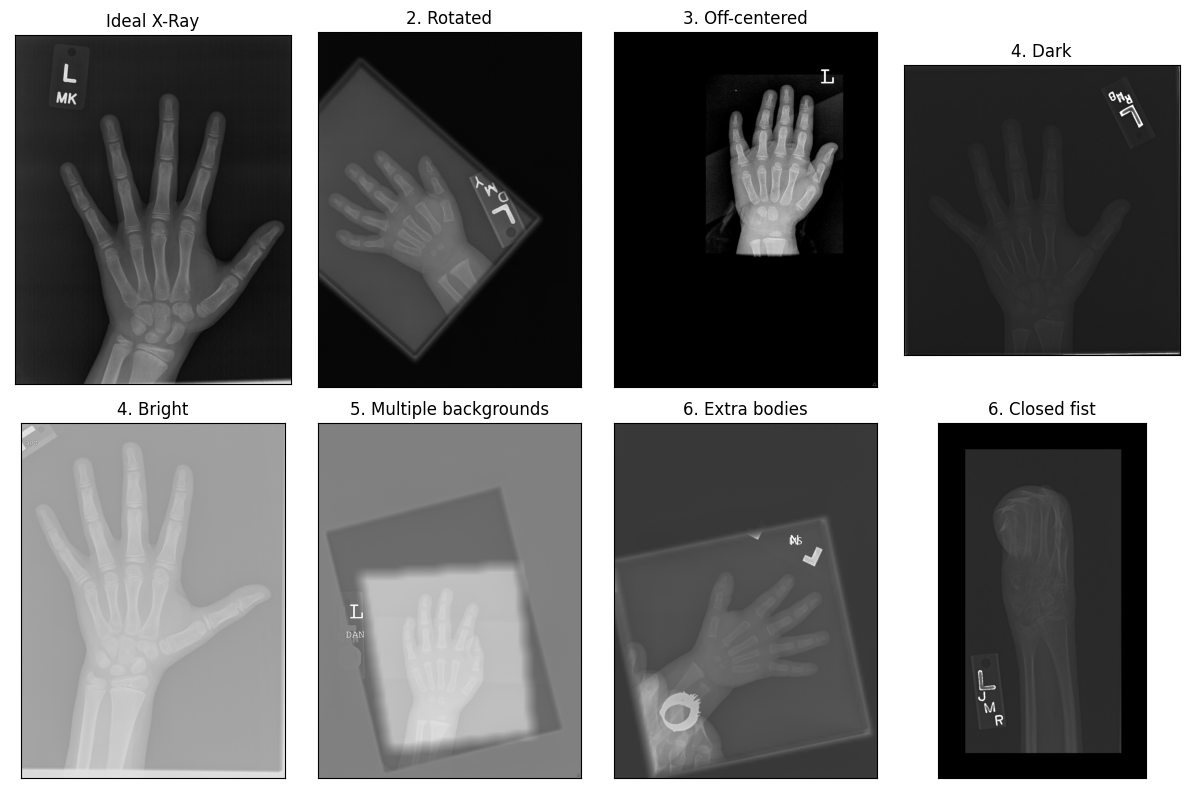

In [18]:
base_hand = cv2.imread('./data/train/images/3881.png')
rotated_hand = cv2.imread('./data/train/images/1905.png')
off_centered_hand = cv2.imread('./data/train/images/1590.png')
dark_hand = cv2.imread('./data/train/images/2063.png')
bright_hand = cv2.imread('./data/train/images/1395.png')
multiple_background_hand = cv2.imread('./data/train/images/1378.png')
extra_bodied_hand = cv2.imread('./data/train/images/2133.png')
closed_hand = cv2.imread('./data/train/images/3885.png')

plt.figure(figsize=(12, 8))
plot_side_by_side(
    [base_hand, rotated_hand, off_centered_hand, dark_hand, bright_hand, multiple_background_hand, extra_bodied_hand,
     closed_hand],
    ['Ideal X-Ray', '2. Rotated', '3. Off-centered', '4. Dark', '4. Bright', '5. Multiple backgrounds', '6. Extra bodies',
     '6. Closed fist'],
    max_per_column=4, labels=False)
plt.tight_layout()
plt.savefig('./report_images/hands.png')

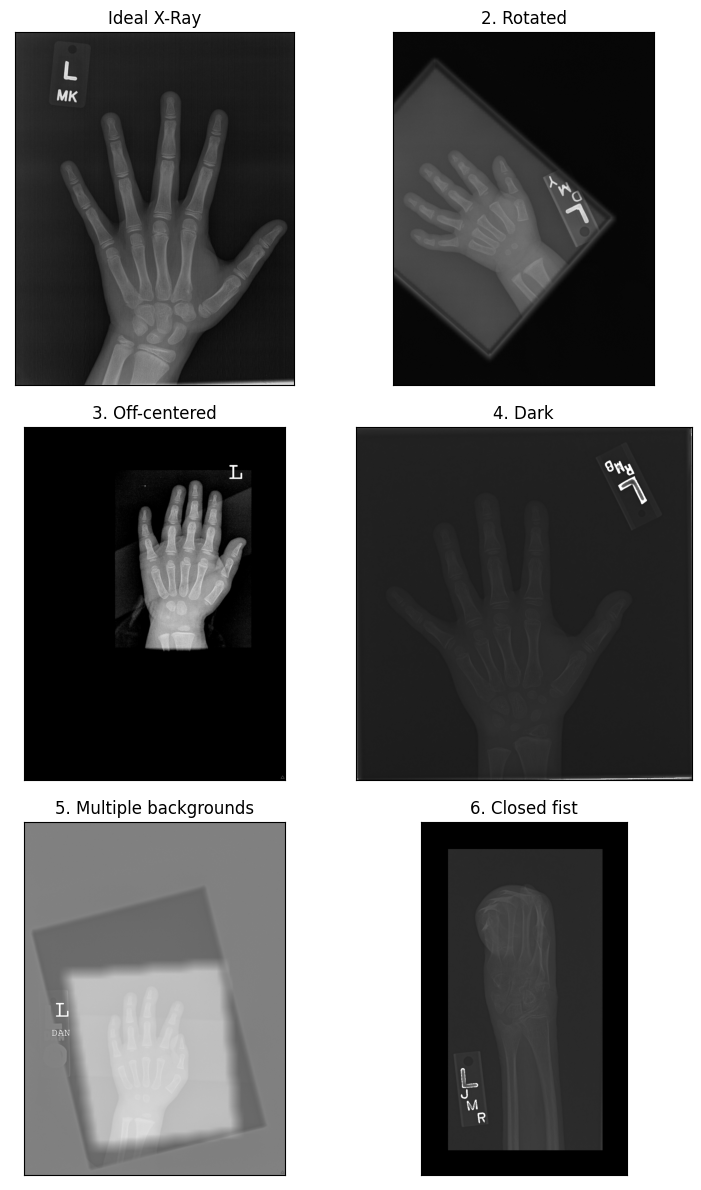

In [45]:
plt.figure(figsize=(8, 12))
plot_side_by_side(
    [base_hand, rotated_hand, off_centered_hand, dark_hand, multiple_background_hand, closed_hand],
    ['Ideal X-Ray', '2. Rotated', '3. Off-centered', '4. Dark', '5. Multiple backgrounds', '6. Closed fist'],
    max_per_column=2, labels=False)
plt.tight_layout()
plt.savefig('./report_images/hands_vertical.png')

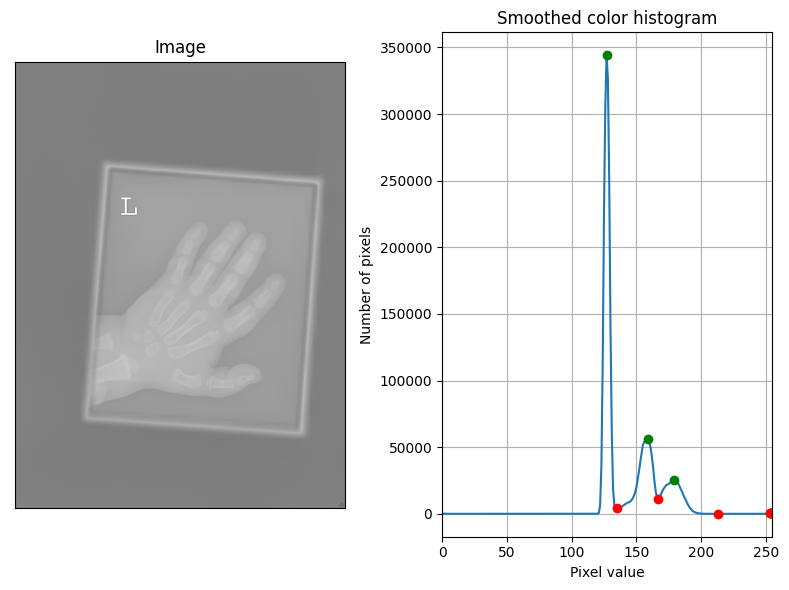

In [27]:
example = cv2.imread('./data/train/images/1402.png', 0)
plt.figure(figsize=(8, 6))
_ = plot_histograms(example.copy(), plot_non_smooth=False)
plt.tight_layout()
plt.savefig('./report_images/histogram.png')

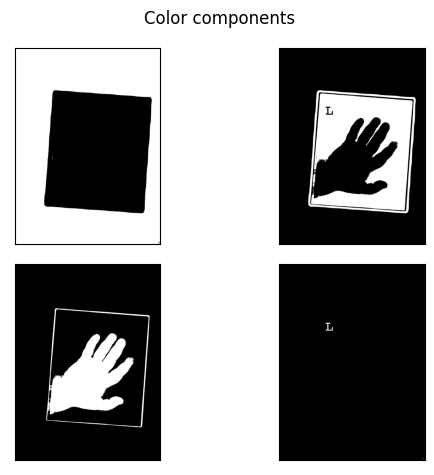

In [41]:
components = get_components(example.copy())
plot_side_by_side(components, max_per_column=2, labels=False)
plt.suptitle('Color components')
plt.tight_layout()
plt.savefig('./report_images/components.png')

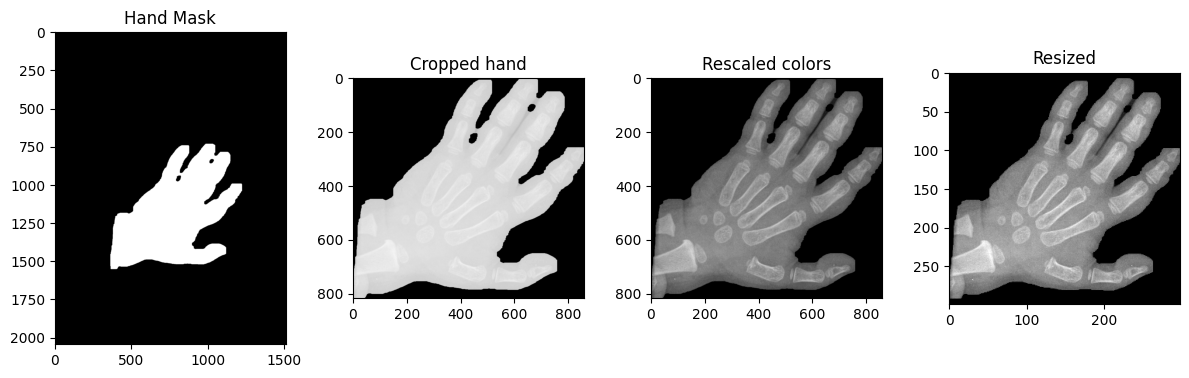

In [42]:
mask = get_hand_components(example)

mask = remove_noise(mask)
mask = remove_lines(mask, line_width=15)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)


mask = mask == 255
masked = example.copy()
masked[~mask] = 0

y_nonzero, x_nonzero = np.nonzero(masked)
cropped = masked[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

minval = np.min(cropped[np.nonzero(cropped)])
maxval = np.max(cropped[np.nonzero(cropped)])
rescaled = np.interp(cropped, (minval, maxval), (0, 255))
rescaled = rescaled.astype(np.uint8)


resized = reshape(rescaled, 299)

plt.figure(figsize=(12,6))
plot_side_by_side([mask, cropped, rescaled, resized], ['Hand Mask', 'Cropped hand', 'Rescaled colors', 'Resized'])
plt.tight_layout()

plt.savefig('./report_images/crop_rescale.png')

In [44]:
np.sqrt(8.23e-3)*200

18.14386948806676